In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

# Synthetic data

In [617]:
X1 = numpy.array(numpy.arange(0, 10, 1)).reshape((-1, 1))
y1 = 1. + 1. * X1.reshape(-1) + 1.*numpy.random.rand(len(X1))

X2 = numpy.array(numpy.arange(0, 10, 1)).reshape((-1, 1))
y2 = -4.5 + 3. * X2.reshape(-1) + 1.*numpy.random.rand(len(X2))

X3 = numpy.array(numpy.arange(0, 10, 1)).reshape((-1, 1))
y3 = 4.5 + -1. * X2.reshape(-1) + 1.*numpy.random.rand(len(X2))

X = numpy.concatenate((X1, X2, X3), axis=0) 
y = numpy.concatenate((y1, y2, y3), axis=0)

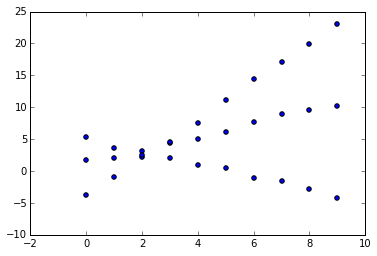

In [618]:
plt.scatter(X, y)
plt.show()

In [721]:
#%%px

import numpy
import pandas
from sklearn.linear_model import LinearRegression
import itertools, random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score


class JustLinearRegression(object):

    def __init__(self):

        self.regressor = None # regressor's class

    def fit(self, X, y):

        qlr = LinearRegression()
        qlr.fit(X, y)

        self.regressor = qlr

        if len(X) > 2:
            score = numpy.sqrt(1. * (numpy.abs(qlr.predict(X) - y)**2).sum() / (len(X) - 2))
        else:
            score = numpy.sqrt(1. * (numpy.abs(qlr.predict(X) - y)**2).sum() / (len(X) - 1))

        return score, qlr


    def predict(self, X):

        return self.regressor.predict(X)


class MultiLinearRegression(object):

    def __init__(self, n_tracks, 
                 n=4, 
                 subsample=1., 
                 x_unique=True, 
                 n_neighbors=10, 
                 step=0.05,  
                 classifier=None):

        self.n = n
        self.subsample = subsample
        self.x_unique = x_unique
        self.n_neighbors = n_neighbors
        self.step = step
        self.n_tracks = n_tracks
        self.classifier = classifier
        self.unique_sorted_dists = []
        self.unique_sorted_indeces = []


    def get_index_combinations(self, X, n):

        index_combinations = []

        indeces = range(len(X))
        random.seed = 42

        for one_combination in itertools.combinations(indeces, n):
            
            if self.subsample >= random.random():

                if self.x_unique:

                    X_one = X[list(one_combination)]
                    X_one_unique = numpy.unique(X_one)

                    if len(X_one_unique) == n:

                        index_combinations.append(list(one_combination))

                else:

                    index_combinations.append(list(one_combination))

        return index_combinations



    def fit_lines(self, X, y):

        scores_list = []
        lrs_list = []

        indexes_list = self.get_index_combinations(X, self.n)

        for ind in indexes_list:

            ind = list(ind)

            X_step = X[ind]
            y_step = y[ind]

            mlr = JustLinearRegression()
            score, lr = mlr.fit(X_step, y_step)
            
            scores_list.append(score)
            lrs_list.append(lr)

        return numpy.array(scores_list), numpy.array(lrs_list), numpy.array(indexes_list)
    
    def knn_max_density(self, X, n_neighbors, step):

        ss = StandardScaler()
        ss.fit(X)
        X_standart = ss.transform(X)

        passed_points_indeces = range(len(X_standart))
        X_passed_standart = X_standart

        while len(X_passed_standart) > n_neighbors:

            knn = NearestNeighbors(n_neighbors=n_neighbors, leaf_size=100)
            knn.fit(X_passed_standart)
            knn_dists, knn_indeces = knn.kneighbors()

            knn_dists_mean = knn_dists.mean(axis=1)

            n_points = max(1, int(step * len(X_passed_standart)))
            passed_points_indeces = knn_dists_mean.argsort()[:-n_points]
            knn_dists_mean.sort()

            X_passed_standart = X_passed_standart[passed_points_indeces]
            
        X_passed = ss.inverse_transform(X_passed_standart)

        return X_passed


    def get_tracks(self, X, n_tracks):

        ss = StandardScaler()
        ss.fit(X)

        transformed_tracks = ss.transform(X).mean(axis=0)
        tracks = ss.inverse_transform(transformed_tracks)
            
        return tracks
    
    def _select_array(self, array):
#         std = 0
#         square = 0
#         last_num = len(array)
#         for num, i in enumerate(array):

#             square += i**2
#             std = numpy.sqrt(1.*square/(num))
#             #square += i**2

#             if 2. * std < i and num >= self.n:
#                 last_num = num
#                 break
                
#         res = range(last_num)

        max_model = None
        max_score = -1

        for n_clusters in [2, 3, 4]:

            km = KMeans(n_clusters=3)
            km.fit(array.reshape(-1, 1))

            score = silhouette_score(array.reshape(-1, 1), km.labels_)

            if score > max_score:

                max_score  = score
                max_model = km


        if max_score >= 0.7:

            min_cluster_id = max_model.cluster_centers_.reshape(-1).argsort()[0]
            indeces = numpy.arange(len(array))[max_model.labels_ == min_cluster_id]

        else:

            indeces = numpy.arange(len(array))
                
        return indeces
    
    def get_points(self, X, y, track):
        
        dists = numpy.abs(y - (track[:-1] * X).sum(axis=1) - track[-1])
        sorted_dists_indeces = dists.argsort()
        
        indeces = numpy.array(range(len(X)))

        sorted_dists = dists[sorted_dists_indeces]
        sorted_X = X[sorted_dists_indeces]
        sorted_y = y[sorted_dists_indeces]
        sorted_indeces = indeces[sorted_dists_indeces]

        unique, index = numpy.unique(sorted_X, return_index=True)

        unique_dists = sorted_dists[index]
        unique_X = sorted_X[index]
        unique_y = sorted_y[index]
        unique_indeces = sorted_indeces[index]

        sorted_dists_indeces = unique_dists.argsort()

        unique_sorted_dists = unique_dists[sorted_dists_indeces]
        unique_sorted_X = unique_X[sorted_dists_indeces]
        unique_sorted_y = unique_y[sorted_dists_indeces]
        unique_sorted_indeces = unique_indeces[sorted_dists_indeces]
        
        self.unique_sorted_dists.append(unique_sorted_dists)
        self.unique_sorted_indeces.append(unique_sorted_indeces)
        
        track_indeces = self._select_array(unique_sorted_dists)
        
        return unique_sorted_X[track_indeces], unique_sorted_y[track_indeces], unique_sorted_indeces[track_indeces]
        
        
        
    def _fit_satellite(self, scores, lrs):
        
        ks = numpy.array([lr.coef_ for lr in lrs])
        bs = numpy.array([lr.intercept_ for lr in lrs]).reshape((-1,1))
        
        track_candidates = numpy.concatenate((ks, bs), axis=1)
        
        n_neighbors = self.n_neighbors
        step = self.step
        track_candidates_dense = self.knn_max_density(track_candidates, n_neighbors, step)
        
        
        tracks = self.get_tracks(track_candidates_dense, self.n_tracks)
        
        return tracks
    
    def _classification(self, scores, lrs, indeces):
        
        ks = numpy.array([lr.coef_ for lr in lrs])
        bs = numpy.array([lr.intercept_ for lr in lrs]).reshape((-1,1))
        
        X = numpy.concatenate((scores.reshape(-1,1), ks, bs.reshape(-1,1)), axis=1)
        y_predict = self.classifier.predict(X)
        
        return scores[y_predict == 1], lrs[y_predict == 1], indeces[y_predict == 1]
    
    def _isAinB(self, A, B):
    
        return len(set(A) & set(B)) != 0
    
    def _get_all_tracks(self, X, y, scores, lrs, indeces, unique_index):
        
        tracks = []
        tracks_labels = -1 * numpy.ones(len(X))
        
        self.qw = []
        
        if unique_index == None:
            
            scores_curr = scores.copy()
            lrs_curr = lrs.copy()
            looked_inds = []
            
            for num in range(self.n_tracks):
                
                one_track = self._fit_satellite(scores_curr, lrs_curr)
                one_track_X, one_track_y, one_track_indeces = self.get_points(X, y, one_track)
                tracks_labels[one_track_indeces] = num
                tracks.append(one_track)
                
                self.qw.append(one_track_indeces)
                
                looked_inds += list(one_track_indeces)
                
                selection = numpy.array([not self._isAinB(i, looked_inds) for i in indeces])
                scores_curr = scores[selection]
                lrs_curr = lrs[selection]
                
        return tracks, tracks_labels
                
    
    def fit(self, X, y, unique_index=None):
        
        scores, lrs, indeces = self.fit_lines(X, y)
        
        if self.classifier != None:
            
            scores, lrs, indeces = self._classification(scores, lrs, indeces)
            self.scores_ = scores
            self.lrs_ = lrs
            self.indeces_ = indeces
        
            tracks, tracks_labels = self._get_all_tracks(X, y, scores, lrs, indeces, unique_index)
        
        else:
            
            self.scores_ = scores
            self.lrs_ = lrs
            self.indeces_ = indeces
        
            tracks, tracks_labels = self._get_all_tracks(X, y, scores, lrs, indeces, unique_index)
            
        
        self.tracks_ = tracks
        self.labels_ = tracks_labels


    def predict(self, X):
        
        predictions = []
        
        for track in self.tracks_:
            
            y_predict = (track[:-1] * X).sum(axis=1) + track[-1]
            predictions.append(y_predict)
            
        return numpy.array(predictions)

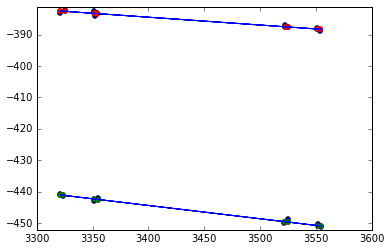

CPU times: user 2.58 s, sys: 31 ms, total: 2.61 s
Wall time: 2.74 s


In [853]:
%%time
rmlr = MultiLinearRegression(n_tracks=2, 
                             n=3, 
                             subsample=1, 
                             n_neighbors=10, 
                             step=0.1,  
                             classifier=None)
rmlr.fit(X, y)
predictions = rmlr.predict(X)

tracks = rmlr.tracks_
tracks_labels = rmlr.labels_
scores = rmlr.scores_
lrs = rmlr.lrs_



plt.scatter(X, y)
colors = ['r', 'g', 'm']
for num, track in enumerate(tracks):
    plt.scatter(X[tracks_labels == num], y[tracks_labels == num], color=colors[num])
    #plt.scatter(X[rmlr.qw[num]], y[rmlr.qw[num]], color=colors[num])
    plt.plot(X, predictions[num], color='b')
    
plt.ylim(y.min()-1, y.max()+1)
plt.show()

In [849]:
trtr

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [850]:
print tracks_labels[tracks_labels == 0]
print tracks_labels[tracks_labels == 1]

print tr[tracks_labels == 0]
print tr[tracks_labels == 1]

print numpy.unique(ind[tracks_labels == 0])
print numpy.unique(ind[tracks_labels == 1])

[ 0.  0.  0.]
[ 1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.]
[ 2.  2.  2.  2.  2.  2.  2.]
[86882 86883 86884]
[86876 86885 86886 86887 86893 86894 86895]


In [802]:
indeces

array([0, 1, 2, 3, 4, 5])

In [778]:
tracks

[array([ -2.81628480e-02,   8.39739410e+01])]

In [779]:
dists = rmlr.unique_sorted_dists[0]
dists

array([  6.79845945e-04,   3.79059644e-03,   3.88447968e-03,
         4.27454742e-03,   4.95581238e-03,   7.60537035e-02,
         2.90075732e-01,   3.67244702e-01,   8.50950209e+01])

In [750]:
inds = rmlr.unique_sorted_indeces[1]
inds

array([23, 10, 21,  8, 19,  5, 15,  0, 13])

In [598]:
dists = numpy.array([1.1, 1.2, 1.3, 1.4])

In [756]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)
km.fit(dists.reshape(-1, 1))
print km.labels_
print km.cluster_centers_
print silhouette_score(dists.reshape(-1, 1), km.labels_)
labs = numpy.zeros(len(dists))
labs[-1:] = 1
print silhouette_score(dists.reshape(-1, 1), labs)
cluster_id = numpy.arange(len(km.cluster_centers_))[km.cluster_centers_.reshape(-1)==km.cluster_centers_.min()]
numpy.arange(len(dists))[km.labels_ == cluster_id]

[0 0 0 0 0 0 0 0 1]
[[  0.09386787]
 [ 85.0949168 ]]
0.998424085325
0.998424085325


array([0, 1, 2, 3, 4, 5, 6, 7])

In [781]:
max_model = None
max_score = -1

for n_clusters in [2, 3, 4]:
    
    km = KMeans(n_clusters=3)
    km.fit(dists.reshape(-1, 1))
    
    score = silhouette_score(dists.reshape(-1, 1), km.labels_)
    
    if score > max_score:
        
        max_score  = score
        max_model = km
        

if max_score >= 0.7:
    
    min_cluster_id = max_model.cluster_centers_.reshape(-1).argsort()[0]
    print max_model.cluster_centers_.reshape(-1).argsort()[0], max_model.cluster_centers_
    indeces = numpy.arange(len(dists))[max_model.labels_ == min_cluster_id]
    print max_model.labels_
    
else:
    
    indeces = numpy.arange(len(dists))

print indeces

    
    

0 [[  1.56064976e-02]
 [  8.50950209e+01]
 [  3.28660217e-01]]
[0 0 0 0 0 0 2 2 1]
[0 1 2 3 4 5]


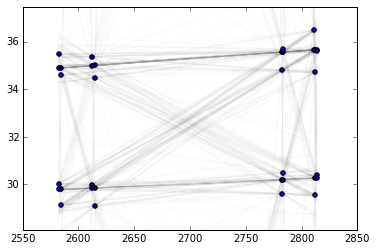

In [792]:
plt.scatter(X, y)
for lr, score in zip(lrs, scores):
    plt.plot(X, lr.predict(X), alpha=0.01 * min(1, 1./score), color='0')
    
plt.ylim(y.min() - 1, y.max() + 1)
plt.show()

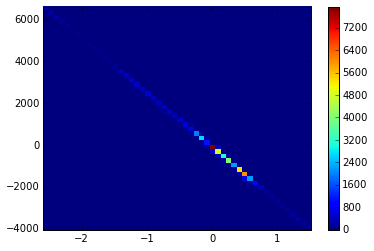

CPU times: user 361 ms, sys: 11.9 ms, total: 373 ms
Wall time: 430 ms


In [658]:
%%time
ks = numpy.array([lr.coef_[0] for lr in lrs])
bs = numpy.array([lr.intercept_ for lr in lrs])

a = ks
b = bs
ab = numpy.concatenate((a.reshape(-1,1),b.reshape(-1,1)), axis=1)

plt.hist2d(a, b, bins=50, range=[[numpy.percentile(a, 5), numpy.percentile(a, 95)], 
                                 [numpy.percentile(b, 5), numpy.percentile(b, 95)]])
plt.colorbar()
plt.show()

# Classifier

In [14]:
def R():
    
    return 20. * (numpy.random.rand() - 0.5)

In [15]:
from sklearn.linear_model import LinearRegression

data = pandas.DataFrame(columns=['score', 'k', 'b', 'label'])

for i in range(1000):

    X1 = numpy.array(numpy.arange(0, 10, 1)).reshape((-1, 1))
    y1 = R() + R() * X1.reshape(-1) + 2. * numpy.random.rand() *numpy.random.rand(len(X1))

    X2 = numpy.array(numpy.arange(0, 10, 1)).reshape((-1, 1))
    y2 = R() + R() * X2.reshape(-1) + 2. * numpy.random.rand() *numpy.random.rand(len(X2))

    mlr = JustLinearRegression()
    score, lr = mlr.fit(X1, y1)
    data.loc[len(data)] = [score, lr.coef_[0], lr.intercept_, 1]

    mlr = JustLinearRegression()
    score, lr = mlr.fit(X2, y2)
    data.loc[len(data)] = [score, lr.coef_[0], lr.intercept_, 1]

    X = numpy.concatenate((X1[:5], X2[5:]), axis=0) 
    y = numpy.concatenate((y1[:5], y2[5:]), axis=0)
    mlr = JustLinearRegression()
    score, lr = mlr.fit(X, y)
    data.loc[len(data)] = [score, lr.coef_[0], lr.intercept_, 0]

    X = numpy.concatenate((X1[5:], X2[:5]), axis=0) 
    y = numpy.concatenate((y1[5:], y2[:5]), axis=0)
    mlr = JustLinearRegression()
    score, lr = mlr.fit(X, y)
    data.loc[len(data)] = [score, lr.coef_[0], lr.intercept_, 0]

In [20]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier

X_data = data[['score', 'k', 'b']].values
y_data = data[['label']].values.reshape(-1)

from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=3, 
                             subsample=0.5, max_depth=8)
folding = FoldingClassifier(xgb_base, n_folds=10, random_state=11)
%time folding.fit(X_data, y_data)

CPU times: user 4.07 s, sys: 2.1 s, total: 6.17 s
Wall time: 4.07 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.1, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2'], n_folds=10,
         parallel_profile=None, random_state=11)

KFold prediction using random classifier (length of data passed not equal to length of train)


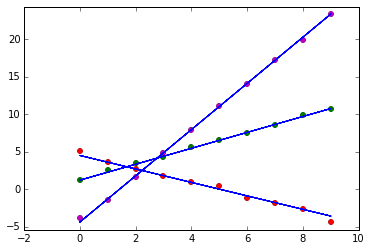

CPU times: user 758 ms, sys: 10.1 ms, total: 768 ms
Wall time: 764 ms


In [23]:
%%time
rmlr = MultiLinearRegression(n_tracks=3, 
                             n=3, 
                             subsample=0.5, 
                             n_neighbors=10, 
                             step=0.1,  
                             classifier=folding)
rmlr.fit(X, y)
predictions = rmlr.predict(X)

tracks = rmlr.tracks_
tracks_labels = rmlr.labels_
scores = rmlr.scores_
lrs = rmlr.lrs_



plt.scatter(X, y)
colors = ['r', 'g', 'm']
for num, track in enumerate(tracks):
    plt.scatter(X[tracks_labels == num], y[tracks_labels == num], color=colors[num])
    plt.plot(X, predictions[num], color='b')
    
plt.ylim(y.min()-1, y.max()+1)
plt.show()

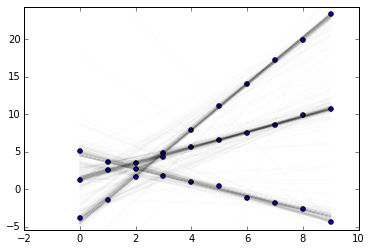

In [24]:
plt.scatter(X, y)
for lr, score in zip(lrs, scores):
    plt.plot(X, lr.predict(X), alpha=0.01 * min(1, 1./score), color='0')
    
plt.ylim(y.min() - 1, y.max() + 1)
plt.show()

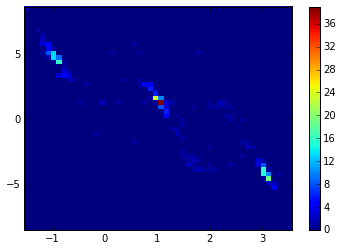

CPU times: user 237 ms, sys: 13.1 ms, total: 250 ms
Wall time: 245 ms


In [26]:
%%time
ks = numpy.array([lr.coef_[0] for lr in lrs])
bs = numpy.array([lr.intercept_ for lr in lrs])

a = ks
b = bs
ab = numpy.concatenate((a.reshape(-1,1),b.reshape(-1,1)), axis=1)

plt.hist2d(a, b, bins=50, range=[[numpy.percentile(a, 1), numpy.percentile(a, 99)], 
                                 [numpy.percentile(b, 1), numpy.percentile(b, 99)]])
plt.colorbar()
plt.show()

# SHiP

In [817]:
import os, sys
sys.path.append('../functions')
from Y_views import *
import cPickle as pickle

all_hits = pandas.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index

file_pickle = open('./Data/reco_tracks_for_pattern_recognition_valid.pkl', 'rb')
reconstructible_events_valid_pkl = pickle.load(file_pickle)
file_pickle.close()
reconstructible_events_valid = reconstructible_events_valid_pkl


all_reco_hits, _ = modify_for_yz_analysis_3_4(all_hits)
all_reco_hits.head()

,Unnamed: 0,Unnamed: 0.1,Bits,TrackID,Px,Py,Pz,Time,Length,ELoss,...,event,k,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Index,Wy,Wz
58,58,58,33554432,3,-0.239122,0.376364,25.824701,408.579224,0.226039,1.363781e-07,...,2,17,3,0,0,0,278,58,11.4286,3321.15
193,193,193,50331648,32,0.239283,-0.270312,0.272903,416.023590,0.751577,1.859432e-06,...,3,77,3,0,0,0,556,193,-477.8514,3321.15
236,236,236,50331648,51,0.028874,-0.201159,0.254977,410.272675,0.978475,3.383096e-06,...,3,120,3,0,0,0,469,236,-324.7314,3321.15
1949,1949,1949,50331648,136,0.043595,0.134798,1.065308,408.778778,0.446474,2.783199e-06,...,3,1833,3,0,0,0,352,1949,-118.8114,3321.15
2824,2824,2824,33554432,3,0.413380,-0.735693,33.000866,408.592010,0.857140,2.299772e-06,...,5,23,3,0,0,0,347,2824,-110.0114,3321.15


In [851]:
event_id =  1967#381#518#1756#27
event = all_reco_hits[all_reco_hits['event'] == event_id]

In [852]:
XX = event.Wz.values
yy = event.Wy.values
rr = 1*event.dist2Wire.values
ii = event.index
trtr = event.TrackID.values

X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
y = numpy.concatenate((yy+rr, yy-rr), axis=0) 
ind = numpy.concatenate((ii, ii), axis=0) 
tr = numpy.concatenate((trtr, trtr), axis=0)

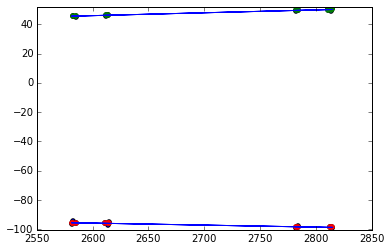

CPU times: user 1.69 s, sys: 13.2 ms, total: 1.71 s
Wall time: 1.72 s


In [145]:
%%time
rmlr = MultiLinearRegression(n_tracks=2, 
                             n=3, 
                             subsample=0.5, 
                             n_neighbors=10, 
                             step=0.1,  
                             classifier=None)
rmlr.fit(X, y)
predictions = rmlr.predict(X)

tracks = rmlr.tracks_
tracks_labels = rmlr.labels_
scores = rmlr.scores_
lrs = rmlr.lrs_



plt.scatter(X, y)
colors = ['r', 'g', 'm']
for num, track in enumerate(tracks):
    plt.scatter(X[tracks_labels == num], y[tracks_labels == num], color=colors[num])
    plt.plot(X, predictions[num], color='b')
    
plt.ylim(y.min()-1, y.max()+1)
plt.show()

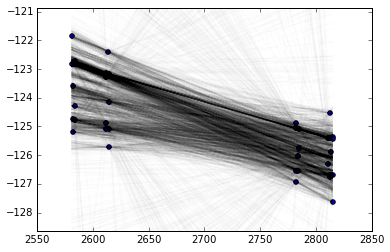

In [84]:
plt.scatter(X, y)
for lr, score in zip(lrs, scores):
    plt.plot(X, lr.predict(X), alpha=0.01 * min(1, 1./score), color='0')
    
plt.ylim(y.min() - 1, y.max() + 1)
plt.show()

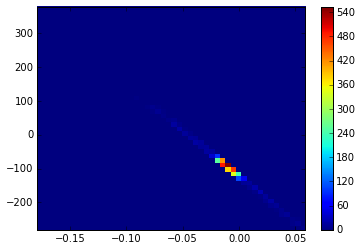

CPU times: user 248 ms, sys: 8.9 ms, total: 257 ms
Wall time: 254 ms


In [85]:
%%time
ks = numpy.array([lr.coef_[0] for lr in lrs])
bs = numpy.array([lr.intercept_ for lr in lrs])

a = ks
b = bs
ab = numpy.concatenate((a.reshape(-1,1),b.reshape(-1,1)), axis=1)

plt.hist2d(a, b, bins=50, range=[[numpy.percentile(a, 1), numpy.percentile(a, 99)], 
                                 [numpy.percentile(b, 1), numpy.percentile(b, 99)]])
plt.colorbar()
plt.show()

# Classifier

In [35]:
from sklearn.linear_model import LinearRegression

data = pandas.DataFrame(columns=['score', 'k', 'b', 'label'])

for event_id in reconstructible_events_valid.keys():
    
    event = all_reco_hits[all_reco_hits.event == event_id]
    
    track2 = event[event.TrackID == 2]
    track3 = event[event.TrackID == 3]
    
    if len(track2)==0 or len(track3)==0:
        continue

    X1 = track2.Z.values.reshape((-1, 1))
    y1 = track2.Y.values

    X2 = track3.Z.values.reshape((-1, 1))
    y2 = track3.Y.values

    mlr = JustLinearRegression()
    score, lr = mlr.fit(X1, y1)
    data.loc[len(data)] = [score, lr.coef_[0], lr.intercept_, 1]

    mlr = JustLinearRegression()
    score, lr = mlr.fit(X2, y2)
    data.loc[len(data)] = [score, lr.coef_[0], lr.intercept_, 1]

    X = numpy.concatenate((X1[track2.StatNb == 1], X2[track3.StatNb == 2]), axis=0) 
    y = numpy.concatenate((y1[track2.StatNb == 1], y2[track3.StatNb == 2]), axis=0)
    mlr = JustLinearRegression()
    score, lr = mlr.fit(X, y)
    data.loc[len(data)] = [score, lr.coef_[0], lr.intercept_, 0]

    X = numpy.concatenate((X1[track2.StatNb == 2], X2[track3.StatNb == 1]), axis=0) 
    y = numpy.concatenate((y1[track2.StatNb == 2], y2[track3.StatNb == 1]), axis=0)
    mlr = JustLinearRegression()
    score, lr = mlr.fit(X, y)
    data.loc[len(data)] = [score, lr.coef_[0], lr.intercept_, 0]

In [36]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier

X_data = data[['score', 'k', 'b']].values
y_data = data[['label']].values.reshape(-1)

from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=3, 
                             subsample=0.5, max_depth=8)
folding = FoldingClassifier(xgb_base, n_folds=10, random_state=11)
%time folding.fit(X_data, y_data)

CPU times: user 1.49 s, sys: 1.39 s, total: 2.88 s
Wall time: 2.13 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.1, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2'], n_folds=10,
         parallel_profile=None, random_state=11)

In [37]:

y_proba = folding.predict_proba(X_data)[:, 1]
y_predict = folding.predict(X_data)

from sklearn.metrics import roc_auc_score
roc_auc_score(y_data, y_proba)

KFold prediction using folds column
KFold prediction using folds column


0.99784744166746464

In [38]:
event_id =  27#381#518#1756#27
event = all_reco_hits[all_reco_hits['event'] == event_id]
XX = event.Wz.values
yy = event.Wy.values
rr = 1*event.dist2Wire.values

X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
y = numpy.concatenate((yy+rr, yy-rr), axis=0) 

KFold prediction using random classifier (length of data passed not equal to length of train)


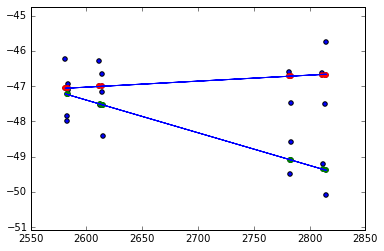

CPU times: user 1.82 s, sys: 39 ms, total: 1.86 s
Wall time: 1.87 s


In [40]:
%%time
rmlr = MultiLinearRegression(n_tracks=2, 
                             n=3, 
                             subsample=0.5, 
                             n_neighbors=10, 
                             step=0.1,  
                             classifier=folding)
rmlr.fit(X, y)
predictions = rmlr.predict(X)

tracks = rmlr.tracks_
tracks_labels = rmlr.labels_
scores = rmlr.scores_
lrs = rmlr.lrs_



plt.scatter(X, y)
colors = ['r', 'g', 'm']
for num, track in enumerate(tracks):
    plt.scatter(X[tracks_labels == num], y[tracks_labels == num], color=colors[num])
    plt.plot(X, predictions[num], color='b')
    
plt.ylim(y.min()-1, y.max()+1)
plt.show()

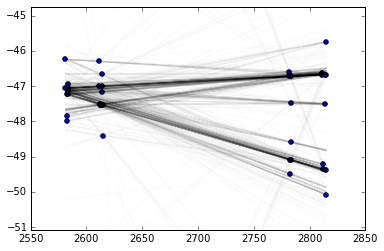

In [41]:
plt.scatter(X, y)
for lr, score in zip(lrs, scores):
    plt.plot(X, lr.predict(X), alpha=0.01 * min(1, 1./score), color='0')
    
plt.ylim(y.min() - 1, y.max() + 1)
plt.show()

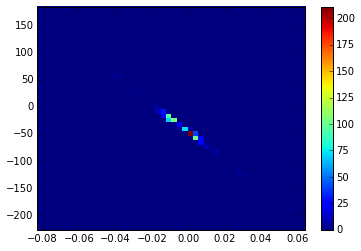

CPU times: user 274 ms, sys: 14.3 ms, total: 288 ms
Wall time: 284 ms


In [42]:
%%time
ks = numpy.array([lr.coef_[0] for lr in lrs])
bs = numpy.array([lr.intercept_ for lr in lrs])

a = ks
b = bs
ab = numpy.concatenate((a.reshape(-1,1),b.reshape(-1,1)), axis=1)

plt.hist2d(a, b, bins=50, range=[[numpy.percentile(a, 1), numpy.percentile(a, 99)], 
                                 [numpy.percentile(b, 1), numpy.percentile(b, 99)]])
plt.colorbar()
plt.show()